###Данные

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip '/content/drive/My Drive/data.zip'

Archive:  /content/drive/My Drive/data.zip
  inflating: avito_data.csv          
  inflating: quora.csv               
  inflating: __MACOSX/._quora.csv    


In [0]:
!pip install pandas scikit-learn gensim matplotlib

In [0]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from sklearn.metrics import classification_report

In [0]:
import tensorflow as tf

In [0]:
avito = pd.read_csv('avito_data.csv').dropna()

In [7]:
avito

,description,deal_probability
0,"Кокон для сна малыша,пользовались меньше месяц...",0.12789
1,"Стойка для одежды, под вешалки. С бутика.",0.00000
2,"В хорошем состоянии, домашний кинотеатр с blu ...",0.43177
3,Продам кресло от0-25кг,0.80323
4,Все вопросы по телефону.,0.20797
...,...,...
1503418,"В хорошем состоянии, ткань плотная (рисунок т...",0.12869
1503420,"Произведем бесплатный замер, изготовим и устан...",0.60000
1503421,"Продам квартиру с отличным ремонтом , две лодж...",0.39569
1503422,Продам красивые туфли в хорошем состоянии!,0.00000


Предобработка

In [0]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [0]:
vocab = Counter()

for text in avito.description:
    vocab.update(preprocess(text))

In [10]:
len(vocab)

1429855

In [0]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [12]:
len(filtered_vocab)

54266

In [0]:
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [0]:
id2word = {i:word for word, i in word2id.items()}

In [0]:

X = []

for text in avito.description:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [0]:
MAX_LEN = max(len(x) for x in X)

In [17]:
MAX_LEN

711

In [0]:
MAX_LEN = 100

In [0]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [20]:
X.shape

(1387148, 100)

In [0]:
y = avito.deal_probability.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state = 12) 

###Первое задание

Склеивание

In [0]:
model = tf.keras.Sequential()
# первым добавляем эмбединг слой
# он каждому слову сопоставит вектор заданой размерности
# также нам нужно передать параметры нашей выборки - размер словаря (input_dim) и длинну текста (input_length)
model.add(tf.keras.layers.Embedding(input_dim=len(word2id), 
                                    input_length=MAX_LEN, output_dim=100))

# вообще для работы с последовательностями нужно использовать рекурентные или сверточные слои
# но с ними мы познакомимся в следующий раз
# Пока, чтобы получить один вектор из последовательности векторов,
# просто склеим их в один 
model.add(tf.keras.layers.Flatten())

# теперь можно добавить любое количество полносвязных слоев, но не обязательно
# model.add(tf.keras.layers.Dense(100, activation='relu'))

# теперь последний слой, выход которого и будет предсказанием
# тут нужно указать количество классов и функцию активации
# в задаче регрессии мы предсказываем одно число == один класс, 
# а активация в задаче регрессии должна быть linear или sigmoid, если число от 0 до 1 (как у нас в задаче)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
#model.add(tf.keras.layers.Dense(1, activation='linear'))

# компилируем модель
# выбираем лосс - функция, по которой модель будет оценивать качество и обновлять веса
# для регрессии стандартно используется mean_squared_error
# выбираем оптимизатор - он влияет на то, как будет обновляться модель 
# (подробнее вот тут - 
# https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3 ).
# По умолчанию можно ставить adam и менять только learning_rate

# также можно указать метрики, по которым уже мы будет оценивать качество модели и принимать решения о смене параметров
# мы используем метрику соревнования RMSE
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam_optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [25]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
         epochs=10)

Epoch 1/10
2574/2574 [==============================] - 201s 78ms/step - loss: 0.0599 - root_mean_squared_error: 0.2447 - val_loss: 0.0582 - val_root_mean_squared_error: 0.2413
Epoch 2/10
2574/2574 [==============================] - 201s 78ms/step - loss: 0.0528 - root_mean_squared_error: 0.2298 - val_loss: 0.0601 - val_root_mean_squared_error: 0.2451
Epoch 3/10
2574/2574 [==============================] - 205s 80ms/step - loss: 0.0423 - root_mean_squared_error: 0.2058 - val_loss: 0.0642 - val_root_mean_squared_error: 0.2533
Epoch 4/10
2574/2574 [==============================] - 201s 78ms/step - loss: 0.0365 - root_mean_squared_error: 0.1910 - val_loss: 0.0683 - val_root_mean_squared_error: 0.2612
Epoch 5/10
2574/2574 [==============================] - 201s 78ms/step - loss: 0.0334 - root_mean_squared_error: 0.1828 - val_loss: 0.0716 - val_root_mean_squared_error: 0.2676
Epoch 6/10
2574/2574 [==============================] - 204s 79ms/step - loss: 0.0315 - root_mean_squared_error: 0.

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


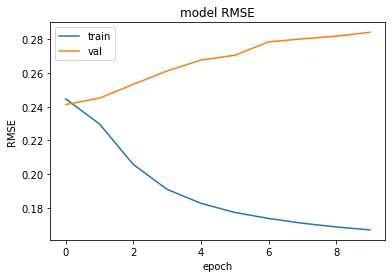

In [26]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Плохо

Усреднение

In [0]:
# input можно не задавать и указывать параметры в эмбединг слое,
# но это может пригодиться, когда мы хотим сделать больше входных слоев
inputs = tf.keras.layers.Input(shape=(100,)) 


embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=10)(inputs) 
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
dense1 = tf.keras.layers.Dense(64, activation='sigmoid')(mean)
dense2 = tf.keras.layers.Dense(64, activation='sigmoid')(dense1) 
outputs = tf.keras.layers.Dense(1, activation='linear')(dense2)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [41]:
model2.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
         epochs=10)

Epoch 1/10
2574/2574 [==============================] - 34s 13ms/step - loss: 0.0695 - root_mean_squared_error: 0.2636 - val_loss: 0.0680 - val_root_mean_squared_error: 0.2607
Epoch 2/10
2574/2574 [==============================] - 35s 14ms/step - loss: 0.0655 - root_mean_squared_error: 0.2559 - val_loss: 0.0635 - val_root_mean_squared_error: 0.2519
Epoch 3/10
2574/2574 [==============================] - 33s 13ms/step - loss: 0.0626 - root_mean_squared_error: 0.2502 - val_loss: 0.0621 - val_root_mean_squared_error: 0.2492
Epoch 4/10
2574/2574 [==============================] - 33s 13ms/step - loss: 0.0616 - root_mean_squared_error: 0.2481 - val_loss: 0.0614 - val_root_mean_squared_error: 0.2478
Epoch 5/10
2574/2574 [==============================] - 34s 13ms/step - loss: 0.0608 - root_mean_squared_error: 0.2467 - val_loss: 0.0609 - val_root_mean_squared_error: 0.2468
Epoch 6/10
2574/2574 [==============================] - 33s 13ms/step - loss: 0.0603 - root_mean_squared_error: 0.2455 -

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


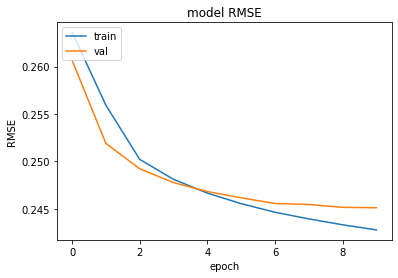

In [42]:
print(model2.history.history.keys())
# summarize history for accuracy
plt.plot(model2.history.history['root_mean_squared_error'])
plt.plot(model2.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

loss: 0.0589 - root_mean_squared_error: 0.2428 - val_loss: 0.0601 - val_root_mean_squared_error: 0.2451

С усреднением лучше, чем со склеиванием, но до уровня конкатенации не дотягивает. 

Конкатенация

In [0]:
# input можно не задавать и указывать параметры в эмбединг слое,
# но это может пригодиться, когда мы хотим сделать больше входных слоев
inputs = tf.keras.layers.Input(shape=(100,)) 


embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=10)(inputs) 
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x,  axis=1))(embeddings) 
dense1 = tf.keras.layers.Dense(64, activation='linear')(mean)
dense2 = tf.keras.layers.Dense(64, activation='sigmoid')(dense1) 
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense2)

model3 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model3.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [98]:
model3.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
         epochs=10)

Epoch 1/10
2574/2574 [==============================] - 33s 13ms/step - loss: 0.0728 - root_mean_squared_error: 0.2698 - val_loss: 0.0607 - val_root_mean_squared_error: 0.2463
Epoch 2/10
2574/2574 [==============================] - 34s 13ms/step - loss: 0.0593 - root_mean_squared_error: 0.2434 - val_loss: 0.0592 - val_root_mean_squared_error: 0.2432
Epoch 3/10
2574/2574 [==============================] - 32s 13ms/step - loss: 0.0577 - root_mean_squared_error: 0.2402 - val_loss: 0.0586 - val_root_mean_squared_error: 0.2420
Epoch 4/10
2574/2574 [==============================] - 34s 13ms/step - loss: 0.0567 - root_mean_squared_error: 0.2382 - val_loss: 0.0586 - val_root_mean_squared_error: 0.2420
Epoch 5/10
2574/2574 [==============================] - 33s 13ms/step - loss: 0.0560 - root_mean_squared_error: 0.2366 - val_loss: 0.0583 - val_root_mean_squared_error: 0.2414
Epoch 6/10
2574/2574 [==============================] - 32s 13ms/step - loss: 0.0555 - root_mean_squared_error: 0.2355 -

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


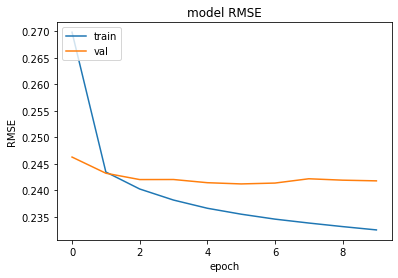

In [99]:
print(model3.history.history.keys())
# summarize history for accuracy
plt.plot(model3.history.history['root_mean_squared_error'])
plt.plot(model3.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

loss: 0.0541 - root_mean_squared_error: 0.2325 - val_loss: 0.0585 - val_root_mean_squared_error: 0.2418 

Это на последней эпохе. С конкатенацией лучше, чем с другими - loss rmse меньше. После шестой иттерации качество упало, но потом опять начало расти. Пробовал ставить меньше эпох, но тогда вообще не сходилась. 

##Второе задание

Свои эмбеддинги

Первый

In [0]:
import gensim

In [0]:
texts = avito.description.apply(preprocess).tolist()

In [0]:
%%time
ft1 = gensim.models.FastText(texts, size=100, iter=2, word_ngrams=3, min_count = 3)

CPU times: user 18min 3s, sys: 3.24 s, total: 18min 6s
Wall time: 10min 8s


In [0]:
weights1 = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue
    
    # для UNK будем использовать какой-то рандомный вектор
    if word == 'UNK':
        weights1[i] = ft1['какоераоваыпаопрвлоа']
    
    try:
        weights1[i] = ft1[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        weights1[i] = ft1['опрагпллирао']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Второй

In [0]:
%%time
ft2 = gensim.models.FastText(texts, size=100, iter=2, word_ngrams=2, min_count = 6)

CPU times: user 17min 4s, sys: 3.37 s, total: 17min 8s
Wall time: 9min 16s


In [0]:
weights2 = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue
    
    # для UNK будем использовать какой-то рандомный вектор
    if word == 'UNK':
        weights2[i] = ft2['какоераоваыпаопрвлоа']
    
    try:
        weights2[i] = ft2[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        weights2[i] = ft2['опрагпллирао']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Модели

In [0]:
#Это для одного фт
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# обучатся заново
embedding1 = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, trainable=False,
                                      weights=[weights1])(inputs, ) 
embedding2 = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, trainable=False,
                                      weights=[weights2])(inputs, )
embeddings = tf.keras.layers.concatenate((embedding1, embedding2), axis=1)
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings) 
dense1 = tf.keras.layers.Dense(64, activation='relu')(mean)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1) 
outputs = tf.keras.layers.Dense(1, activation='linear')(dense2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [0]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
         epochs=30)

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


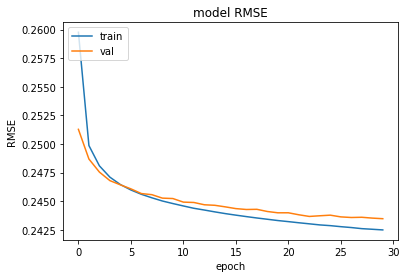

In [0]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

loss: 0.0588 - root_mean_squared_error: 0.2425 - val_loss: 0.0593 - val_root_mean_squared_error: 0.2435

Очень даже сносно. Немного похуже, чем в предыдущем варианте, но, если судить по графику, увеличение иттераций может здесь и качество повысить. 